# Extended Wigner's friend scenario (with GHZ friends)

The extended Wigner's friend scenario (EWFS) with GHZ friends. Consider both "random" and "majority vote" approaches. Only consider the semi-Brukner inequality.

## Imports and setup

In [52]:
import os
from collections import defaultdict
from datetime import datetime

import qiskit
import qiskit_aer
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit.transpiler.passes import RemoveBarriers

from ewfs.noise_models import depolarizing_noise_model, bitflip_model
from ewfs.file_io import save_data
from ewfs.ewfs import (
    ewfs,
    compute_violations,
    decode_results,
    PEEK, 
    REVERSE_1,
    REVERSE_2,
    ANGLES,
    BETA,
    Setting,
)

## Sanity checks (for majority vote approach)

EWFS circuit for setting ('PEEK', 'REVERSE_2'):


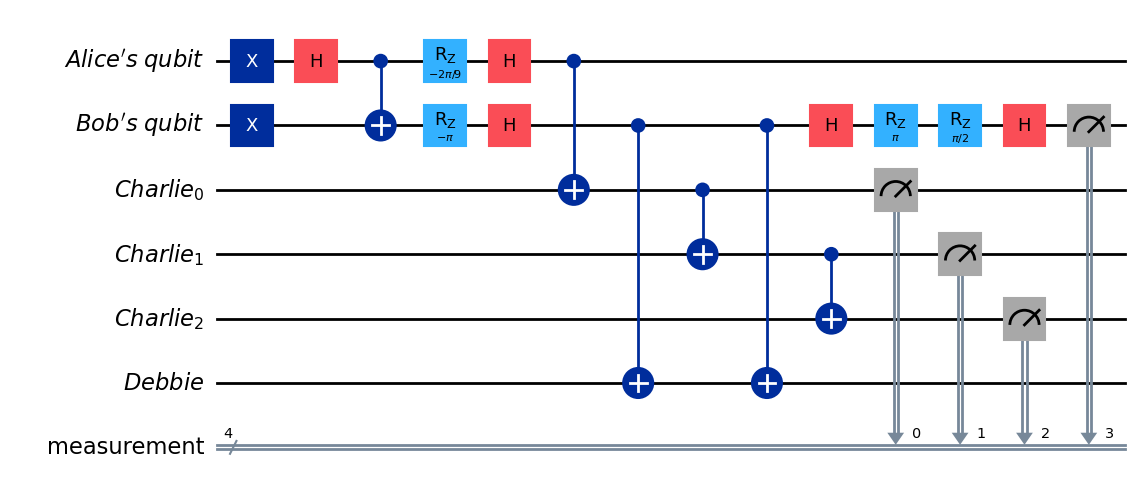

In [53]:
# Print example circuit.
charlie_size = 3
setting = (PEEK, REVERSE_2)

print(f"EWFS circuit for setting {Setting(setting[0]).name, Setting(setting[1]).name}:")
qc = ewfs(setting[0], setting[1], "majority_vote", ANGLES, BETA, charlie_size, 1)
qc.draw("mpl", style="default")

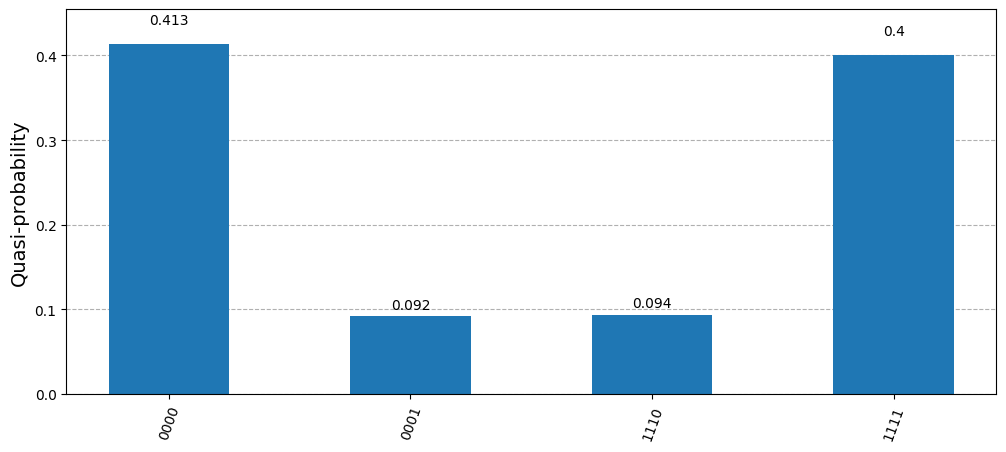

In [54]:
noise_bit_flip = bitflip_model(0.03)
simulator = qiskit_aer.AerSimulator()
transpiled_qc = qiskit.transpile(qc, simulator, basis_gates=noise_bit_flip.basis_gates)

shots = 10_000
job = simulator.run(transpiled_qc, shots=shots)
result = job.result()

counts = result.get_counts()
probabilities = {key[::-1]: value / shots for key, value in counts.items()}

plot_histogram(probabilities, figsize=(12, 5))

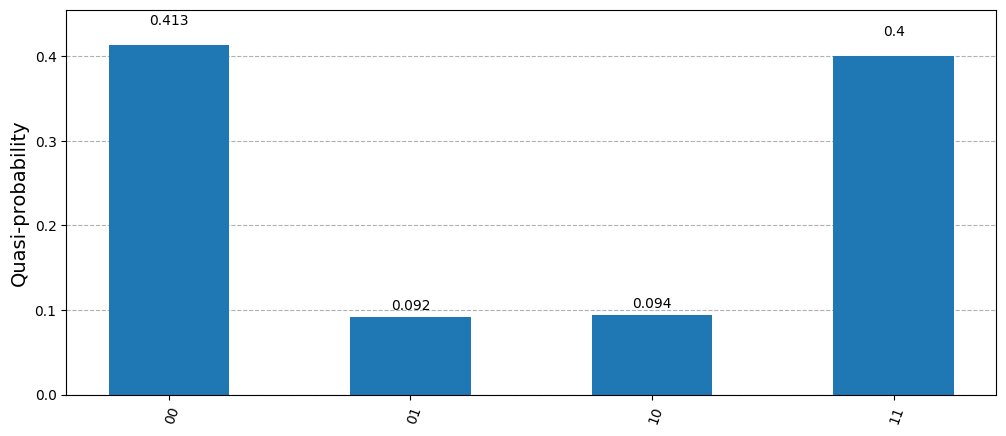

In [55]:
results = {setting: probabilities}
dec_res = decode_results(results, charlie_size)
probs = dec_res[setting]
plot_distribution(probs, figsize=(12, 5))

## Experiment

Run EWFS experiment for a specific number of shots, trials, and over a range of friend sizes.

#### Settings

In [73]:
# Experimental settings:
shots = 10_000
num_trials = 2
friend_sizes = range(1, 3)
strategy = "majority_vote"
save = True

# Set backend and noise model:
backend_name = "aer_simulator"
backend = qiskit_aer.Aer.get_backend(backend_name)
noise_model = None

# Create timestamped directory to save results:
DATA_PATH = os.path.join("..", "data")
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
new_dir_name = f"{strategy}_{backend_name}_{timestamp}"
new_dir_path = os.path.join(DATA_PATH, new_dir_name)

if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path)

#### Run experiment

In [81]:
all_experiment_combos = [
    [PEEK, REVERSE_1],
    [PEEK, REVERSE_2],
    [REVERSE_2, REVERSE_1],
    [REVERSE_2, REVERSE_2],
]

# The tasks dictionary has a key that corresponds to the qubit
# system size with an associated value of the task for that size.
tasks = defaultdict(dict)

# Construct all circuits to be run over all qubit sizes.
for charlie_size in friend_sizes:
    for trial in range(1, num_trials + 1):
        circuits = {}
    
        # Create circuits for each EWFS setting.
        # Note, we remove barriers in the Qiskit circuit.
        for alice, bob in all_experiment_combos:
            circuits[(alice, bob)] = RemoveBarriers()(
                ewfs(alice, bob, strategy, ANGLES, BETA, charlie_size, 1)
            )
    
        # Use backend to transpile circuits.
        transpiled_circuits = {
            k:  qiskit.transpile(circuit, backend, optimization_level=0)
            for k, circuit in circuits.items()
        }
    
        # Run task.
        print(f"Trial {trial} out of {num_trials} for task of {charlie_size=}")
        tasks[trial][charlie_size] = backend.run(
            list(transpiled_circuits.values()),
            shots=shots,
            verbatim=True,
        )
        print(f"Task with task ID: {tasks[trial][charlie_size].job_id()}\n")

Trial 1 out of 2 for task of charlie_size=1
Task with task ID: 7ef5defd-2b90-4eed-908e-d4271f8e8060

Trial 2 out of 2 for task of charlie_size=1
Task with task ID: 818b1848-9631-4451-8520-d9b2229f26f1

Trial 1 out of 2 for task of charlie_size=2
Task with task ID: ffcd70af-e4be-4038-b1c1-2d86c62ca035

Trial 2 out of 2 for task of charlie_size=2
Task with task ID: 0d9832ec-9dd5-4524-b2de-12f8c7a985d5



#### Post-processing

In [85]:
results = {}
post_processed_results = {
    fs: {inequality: [] for inequality in ["semi_brukner"]}
    for fs in friend_sizes
}
for trial in tasks:
    for charlie_size, task in tasks[trial].items():
        print(f"Processing trial {trial} for task with task ID: {task.job_id()}")

        result = task.result()
        for key, count in zip(transpiled_circuits.keys(), result.get_counts()):
            probabilities = {k[::-1]: v / shots for k, v in count.items()}
            results[key] = probabilities
        print(f"Results: {results}")
    
        # Compute violations from result counts.
        violations = compute_violations(
            results=results,
            charlie_size=charlie_size,
            debbie_size=1,
            strategy=strategy,
            verbose=True
        )
        print(f"Violations: {violations}\n")
    
        for key in violations:
            post_processed_results[charlie_size][key].append(violations[key])
    
        # Save data after each trial of each charlie_size.
        if save:
            save_data(results=results,
                      friend_size=charlie_size,
                      trial=trial,
                      shots=shots,
                      data_path=new_dir_path,
                      backend_name=backend_name)

Processing trial 1 for task with task ID: 7ef5defd-2b90-4eed-908e-d4271f8e8060
Results: {(1, 2): {'00': 0.0925, '11': 0.0895, '01': 0.415, '10': 0.403}, (1, 3): {'10': 0.0907, '01': 0.0875, '11': 0.411, '00': 0.4108}, (3, 2): {'10': 0.4457, '11': 0.0545, '00': 0.0602, '01': 0.4396}, (3, 3): {'11': 0.0585, '00': 0.0592, '01': 0.4333, '10': 0.449}}
semi_brukner=0.8148 -- is violated: True
Violations: {'semi_brukner': 0.8148}

Writing data to: ../data/majority_vote_aer_simulator_20240818-093746/aer_simulator_qubits_1_trial_1_shots_10000.pickle
Processing trial 1 for task with task ID: ffcd70af-e4be-4038-b1c1-2d86c62ca035
Results: {(1, 2): {'111': 0.085, '001': 0.4102, '000': 0.0886, '110': 0.4162}, (1, 3): {'001': 0.0916, '111': 0.4087, '110': 0.0881, '000': 0.4116}, (3, 2): {'11': 0.0588, '01': 0.4386, '00': 0.0603, '10': 0.4423}, (3, 3): {'10': 0.438, '01': 0.4432, '00': 0.0608, '11': 0.058}}
semi_brukner=0.8176000000000001 -- is violated: True
Violations: {'semi_brukner': 0.81760000000